PROJECT TEAM: HUA YANG, JENNY LAM, OLIVIA MALAGON

In [1]:
#import libary
import pyspark.pandas as ps
import matplotlib.pyplot as plt
ps.set_option('plotting.backend', 'matplotlib')
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,lit, explode, array
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer,StandardScaler,ChiSqSelector
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,RegressionEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1722405245074_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1722405245074_0003/container_1722405245074_0003_01_000001/pyspark.zip/pyspark/pandas/__init__.py:51: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.

In [2]:
#Load dataset and drop "id"column
#based on our another file already explore descriptive statistics
#we will drop 'id', 'country' for future build model
df = 's3://gba6430-huayang-01/intro/lung_cancer_data.csv'
df = ps.read_csv(df)
df = df.rename(columns={'Unnamed: 0': 'id'})
df = df.drop(columns=['id', 'country'])
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   _c0   age  gender diagnosis_date cancer_stage beginning_of_treatment_date family_history  smoking_status   bmi  cholesterol_level  hypertension  asthma  cirrhosis  other_cancer treatment_type end_treatment_date  survived
0    1  50.0    Male     2023-04-22    Stage III                  2023-05-02            Yes  Passive Smoker  25.9                208             1       0          0             0      Radiation         2024-04-25         0
1    2  65.0    Male     2023-04-07     Stage IV                  2023-04-12             No    Never Smoked  18.9                193             0       0          0             0        Surgery         2025-03-11         0
2    3  51.0  Female     2016-02-07    Stage III                  2016-02-13            Yes   Former Smoker  34.6                249             1       1          1             0        Surgery         2017-04-14         1
3    4  37.0    Male     2023-12-01      Stage I                  2023-12-03            Yes    Never Smo

In [3]:
#check shape
df.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(10000, 17)

In [4]:
#check data info
df.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   _c0                          10000 non-null  int32  
 1   age                          10000 non-null  float64
 2   gender                       10000 non-null  object 
 3   diagnosis_date               10000 non-null  object 
 4   cancer_stage                 10000 non-null  object 
 5   beginning_of_treatment_date  10000 non-null  object 
 6   family_history               10000 non-null  object 
 7   smoking_status               10000 non-null  object 
 8   bmi                          10000 non-null  float64
 9   cholesterol_level            10000 non-null  int32  
 10  hypertension                 10000 non-null  int32  
 11  asthma                       10000 non-null  int32  
 12  cirrhosis                    10000 non-null  int32  
 13  other_cancer  

In [5]:
%%pretty
df.to_spark().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

_c0,age,gender,diagnosis_date,cancer_stage,beginning_of_treatment_date,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
1,50.0,Male,2023-04-22,Stage III,2023-05-02,Yes,Passive Smoker,25.9,208,1,0,0,0,Radiation,2024-04-25,0
2,65.0,Male,2023-04-07,Stage IV,2023-04-12,No,Never Smoked,18.9,193,0,0,0,0,Surgery,2025-03-11,0
3,51.0,Female,2016-02-07,Stage III,2016-02-13,Yes,Former Smoker,34.6,249,1,1,1,0,Surgery,2017-04-14,1
4,37.0,Male,2023-12-01,Stage I,2023-12-03,Yes,Never Smoked,40.2,262,0,0,0,0,Chemotherapy,2024-09-20,0
5,50.0,Male,2023-01-04,Stage II,2023-01-12,Yes,Never Smoked,32.6,300,1,1,0,0,Radiation,2024-03-11,0
6,49.0,Male,2018-05-23,Stage IV,2018-05-30,No,Former Smoker,30.1,300,1,1,0,1,Chemotherapy,2019-07-07,0
7,51.0,Female,2017-02-20,Stage II,2017-02-23,Yes,Former Smoker,44.3,244,1,0,0,0,Combined,2018-10-09,0
8,64.0,Female,2021-03-23,Stage I,2021-04-03,Yes,Passive Smoker,26.9,161,1,0,0,0,Surgery,2023-02-13,0
9,56.0,Male,2021-12-02,Stage III,2021-12-04,Yes,Passive Smoker,40.9,286,1,1,0,0,Chemotherapy,2023-07-07,1
10,48.0,Female,2023-12-26,Stage II,2024-01-08,Yes,Passive Smoker,16.2,223,1,1,1,0,Surgery,2025-08-20,0


In [6]:
#defien a function to plot histogram of numeric features
def plot_hist(df, features, n_rows, n_cols):
    fig, ax = plt.subplots(n_rows, n_cols)
    fig.tight_layout(pad=1.5)
    for i in range(len(features)):
        df[features[i]].hist(ax=ax[i//n_cols, i%n_cols], title=features[i])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

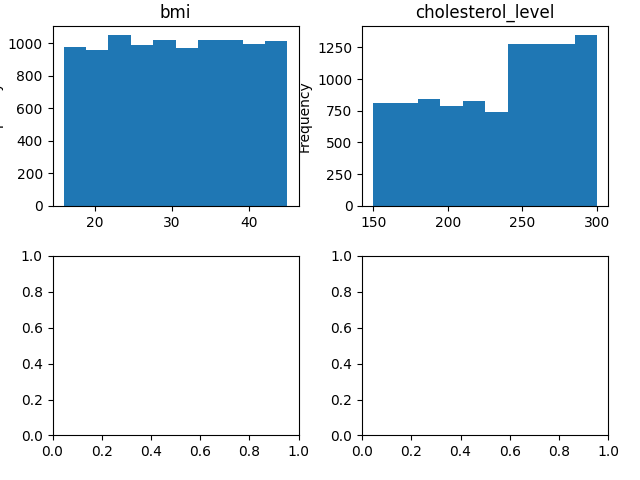

In [7]:
#use histgram plot explore "bmi", "cholesterol_level" numberical columns
features = ["bmi", "cholesterol_level"]
plot_hist(df, features=features, n_rows=2, n_cols=2)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

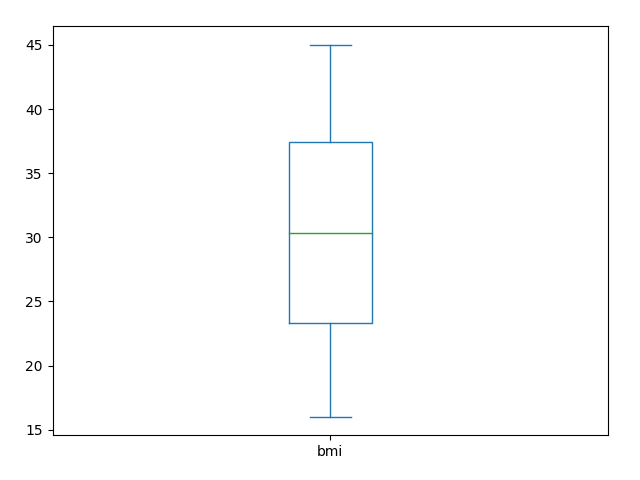

In [8]:
#use boxplot explore "bmi" outlier, the result shows no outlier
plt.clf()
df['bmi'].plot.box()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

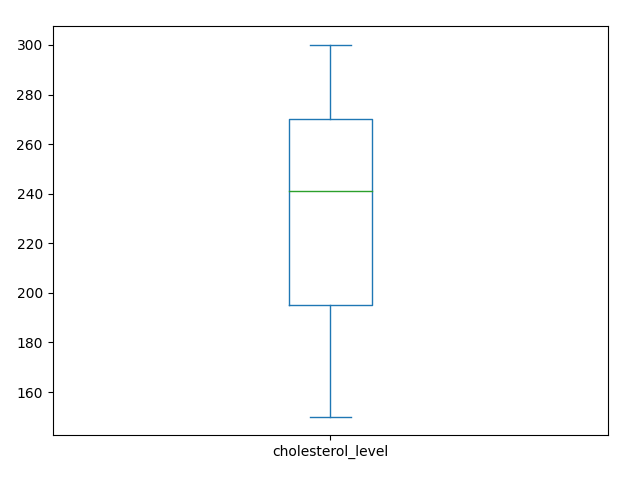

In [9]:
#use boxplot explore "cholesterol_level" outlier, the result shows no outlier
plt.clf()
df["cholesterol_level"].plot.box()
%matplot plt

In [10]:
#change categarical variable as dummies
df = ps.get_dummies(df, columns=["gender","cancer_stage","family_history","smoking_status","treatment_type"], drop_first=False)
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   _c0   age diagnosis_date beginning_of_treatment_date   bmi  cholesterol_level  hypertension  asthma  cirrhosis  other_cancer end_treatment_date  survived  gender_Female  gender_Male  cancer_stage_Stage I  cancer_stage_Stage II  cancer_stage_Stage III  cancer_stage_Stage IV  family_history_No  family_history_Yes  smoking_status_Current Smoker  smoking_status_Former Smoker  smoking_status_Never Smoked  smoking_status_Passive Smoker  treatment_type_Chemotherapy  treatment_type_Combined  treatment_type_Radiation  treatment_type_Surgery
0    1  50.0     2023-04-22                  2023-05-02  25.9                208             1       0          0             0         2024-04-25         0              0            1                     0                      0                       1                      0                  0                   1                              0                             0                            0                              1                       

In [11]:
%%pretty
df.to_spark().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

_c0,age,diagnosis_date,beginning_of_treatment_date,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,end_treatment_date,survived,gender_Female,gender_Male,cancer_stage_Stage I,cancer_stage_Stage II,cancer_stage_Stage III,cancer_stage_Stage IV,family_history_No,family_history_Yes,smoking_status_Current Smoker,smoking_status_Former Smoker,smoking_status_Never Smoked,smoking_status_Passive Smoker,treatment_type_Chemotherapy,treatment_type_Combined,treatment_type_Radiation,treatment_type_Surgery
1,50.0,2023-04-22,2023-05-02,25.9,208,1,0,0,0,2024-04-25,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
2,65.0,2023-04-07,2023-04-12,18.9,193,0,0,0,0,2025-03-11,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1
3,51.0,2016-02-07,2016-02-13,34.6,249,1,1,1,0,2017-04-14,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1
4,37.0,2023-12-01,2023-12-03,40.2,262,0,0,0,0,2024-09-20,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0
5,50.0,2023-01-04,2023-01-12,32.6,300,1,1,0,0,2024-03-11,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0
6,49.0,2018-05-23,2018-05-30,30.1,300,1,1,0,1,2019-07-07,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0
7,51.0,2017-02-20,2017-02-23,44.3,244,1,0,0,0,2018-10-09,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
8,64.0,2021-03-23,2021-04-03,26.9,161,1,0,0,0,2023-02-13,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
9,56.0,2021-12-02,2021-12-04,40.9,286,1,1,0,0,2023-07-07,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0
10,48.0,2023-12-26,2024-01-08,16.2,223,1,1,1,0,2025-08-20,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1


In [12]:
#check again, make sure dataset shape is 10000
df.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(10000, 28)

In [13]:
#ps to pd
import pandas as pd
df = df.to_pandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1722405245074_0003/container_1722405245074_0003_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

In [14]:
import pandas as pd
df['beginning_of_treatment_date'] = pd.to_datetime(df['beginning_of_treatment_date'])
df['end_treatment_date'] = pd.to_datetime(df['end_treatment_date'])
df['duration'] = (df['end_treatment_date'] - df['beginning_of_treatment_date']).dt.days

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
#drop 'diagnosis_date','beginning_of_treatment_date','end_treatment_date' column
df = df.drop(columns=['diagnosis_date','beginning_of_treatment_date','end_treatment_date'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
#panda to pyspark.pandas
psdf = ps.from_pandas(df)
spark_df = psdf.to_spark()
spark_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+----+----+-----------------+------------+------+---------+------------+--------+-------------+-----------+--------------------+---------------------+----------------------+---------------------+-----------------+------------------+-----------------------------+----------------------------+---------------------------+-----------------------------+---------------------------+-----------------------+------------------------+----------------------+--------+
|_c0| age| bmi|cholesterol_level|hypertension|asthma|cirrhosis|other_cancer|survived|gender_Female|gender_Male|cancer_stage_Stage I|cancer_stage_Stage II|cancer_stage_Stage III|cancer_stage_Stage IV|family_history_No|family_history_Yes|smoking_status_Current Smoker|smoking_status_Former Smoker|smoking_status_Never Smoked|smoking_status_Passive Smoker|treatment_type_Chemotherapy|treatment_type_Combined|treatment_type_Radiation|treatment_type_Surgery|duration|
+---+----+----+-----------------+------------+------+---------+-----------

In [27]:
#no '_c0', 'duration', and 'survived'
feature_columns = [col for col in spark_df.columns if col not in ['_c0', 'duration', 'survived']]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
#scale features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(spark_df)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(data)
scaled_data = scaler_model.transform(data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
#linear regression to assess influence of each factor on survival
regression_data = scaled_data.select(col("scaledFeatures").alias("features"), col("survived").alias("label"))
lr = LinearRegression(labelCol="label", featuresCol="features")

#train model
lr_model = lr.fit(regression_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

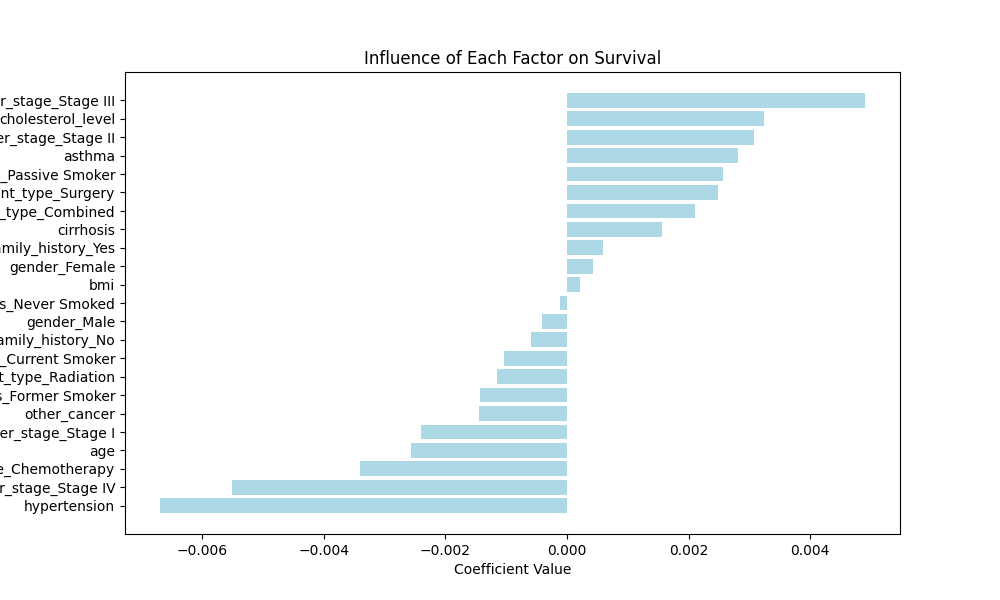

In [35]:
#extract importances feature
feature_importances = lr_model.coefficients.toArray()
feature_importances_df = pd.DataFrame(list(zip(feature_columns, feature_importances)), columns=['Feature', 'Importance'])
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='lightblue')
plt.xlabel('Coefficient Value')
plt.title('Influence of Each Factor on Survival')
plt.gca().invert_yaxis()  # To have the highest importance at the top
plt.show()
%matplot plt

Based on the plot above, we can observe several key influences on survival: Hypertension has the most negative impact on survival, this significant health risk underscores the importance of managing hypertension to improve survival rates. Cancer Stage IV and treatment with chemotherapy also negatively impact survival. This makes sense, as patients undergoing chemotherapy are typically in later stages of cancer, which inherently carries a higher risk of mortality. Older age is associated with a decreased likelihood of survival, which is expected since older individuals generally face more health challenges compared to younger people. When it comes to smoking status, whether someone smokes or not seems to have a smaller impact on survival. However, we can see that being a current smoker has a slight negative influence on survival, while being a passive smoker (exposed to secondhand smoke) shows a slight positive influence. Though the impact is minimal, it still suggests that not smoking is better for survival.

In [36]:
#use scalefeatures to classification with RandomForestClassifier
classification_data = scaled_data.select(col("scaledFeatures").alias("features"), col("survived").alias("label"))

#split data 7/3 and set seed 1000
train_data, test_data = classification_data.randomSplit([0.7, 0.3], seed=1000)


#RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, maxDepth=10)

#train model
rf_model = rf.fit(train_data)

#predictions
predictions = rf_model.transform(test_data)
predictions.show()

#evaluation model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

#get accuracy
print(f"Accuracy: {accuracy}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(23,[0,1,2,3,4,5,...|    0|[77.2070895238683...|[0.77207089523868...|       0.0|
|(23,[0,1,2,3,4,5,...|    0|[78.9616657431123...|[0.78961665743112...|       0.0|
|(23,[0,1,2,3,4,5,...|    0|[79.6400251426392...|[0.79640025142639...|       0.0|
|(23,[0,1,2,3,4,5,...|    1|[72.2633831076196...|[0.72263383107619...|       0.0|
|(23,[0,1,2,3,4,5,...|    1|[76.2839730734672...|[0.76283973073467...|       0.0|
|(23,[0,1,2,3,4,5,...|    0|[78.6852784978344...|[0.78685278497834...|       0.0|
|(23,[0,1,2,3,4,5,...|    0|[74.3046796154980...|[0.74304679615498...|       0.0|
|(23,[0,1,2,3,4,5,...|    1|[79.9206058016707...|[0.79920605801670...|       0.0|
|(23,[0,1,2,3,4,5,...|    0|[77.8430449657976...|[0.77843044965797...|       0.0|
|(23,[0,1,2,3,4,

we can see Accuracy: 0.7893880208333334 which means RandomForestClassifier is performing well 

In [37]:
#Clustering, we choose k=3, we test k=5 and k=7, found best of k=3 get better results
#We also test use Scalefeatures and unScalefeatures, the result shows when use Clustering use UunScalefeatures
#has more better Silhouette score, so we choose use UunScalefeatures.
kmeans = KMeans(featuresCol='features', k=3)

#train tmodel
kmeans_model = kmeans.fit(data)

#prediction
kmeans_predictions = kmeans_model.transform(data)
kmeans_predictions.show()

#evaluation clustering by Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(kmeans_predictions)
print(f"Silhouette with squared euclidean distance: {silhouette}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+----+----+-----------------+------------+------+---------+------------+--------+-------------+-----------+--------------------+---------------------+----------------------+---------------------+-----------------+------------------+-----------------------------+----------------------------+---------------------------+-----------------------------+---------------------------+-----------------------+------------------------+----------------------+--------+--------------------+----------+
|_c0| age| bmi|cholesterol_level|hypertension|asthma|cirrhosis|other_cancer|survived|gender_Female|gender_Male|cancer_stage_Stage I|cancer_stage_Stage II|cancer_stage_Stage III|cancer_stage_Stage IV|family_history_No|family_history_Yes|smoking_status_Current Smoker|smoking_status_Former Smoker|smoking_status_Never Smoked|smoking_status_Passive Smoker|treatment_type_Chemotherapy|treatment_type_Combined|treatment_type_Radiation|treatment_type_Surgery|duration|            features|prediction|
+---+----+

we can see Silhouette with squared euclidean distance: 0.6698249255173816, Silhouette ranges from −1 to +1, anything around 0.5 or more indicates well separated clusters. Based on above the Clustering are well-defined and separated from each other, indicates well separated clusters.